In [9]:
from tqdm import trange
from algs_one_mtx import CBSCFD, LinUCBwithPSI_rank1, LinUCB_SM, CBRAP, LinUCBwithPSI_Batch
from models.dbsl import DBSL

from env_mnist import *

In [10]:
images, labels = load_mnist("datasets/MNIST/raw")
features = images / np.max(np.linalg.norm(images, axis=1))
clusters = group_by_class(features, labels)

print(features.shape)
print([(clusters[k].shape) for k in range(10)])

(60000, 784)
[(5923, 784), (6742, 784), (5958, 784), (6131, 784), (5842, 784), (5421, 784), (5918, 784), (6265, 784), (5851, 784), (5949, 784)]


In [22]:
from scipy.linalg import svd, qr, norm
def getStartingValues(u, v, k):
    Qu, Ru = np.linalg.qr(u)
    Qv, Rv = np.linalg.qr(v)


    small_matrix = Ru @ Rv.T

    try:
        U_s, S, Vh_s = np.linalg.svd(small_matrix, full_matrices=False)
    except np.linalg.LinAlgError:

        print('reg')
        reg = 1e-10 * np.eye(small_matrix.shape[0])
        small_matrix_reg = small_matrix + reg
        U_s, S, Vh_s = np.linalg.svd(small_matrix_reg, full_matrices=False)

    U_s = U_s[:, :k]
    S = S[:k]
    S = np.diag(S)
    Vh_s = Vh_s[:k, :]

    U = Qu @ U_s
    V = Qv @ Vh_s.T
    #print(U.shape)
    #print( U, S, V)

    return U, S, V


def integrator(tilde_Ut, S, tilde_Vt, delta_U, delta_V):
    #print("Integrator called")
    Ut = tilde_Ut.copy()
    Vt = tilde_Vt.copy()
    K1 = Ut @ S + delta_U.dot(delta_V.T.dot(Vt))
    tilde_U1, tilde_S1 = qr(K1,mode = "economic")
    tilde_S0 = tilde_S1 - tilde_U1.T.dot(delta_U.dot(delta_V.T.dot(Vt)))
    L1 = Vt.dot(tilde_S0.T) + delta_V.dot(delta_U.T.dot(tilde_U1))
    tilde_V1, S1 = qr(L1, mode = "economic")
    S1 = S1.T
    return tilde_U1, S1, tilde_V1

def svd_U_V_T(U, V, rank):
    Q_U, R_U = qr(U, mode = "economic")
    Q_V, R_V = qr(V, mode = "economic")

    U_svd, S_svd, V_svd = svd(R_U.dot(R_V.T), full_matrices = False)

    U_svd = U_svd[:, :rank]
    S_svd = S_svd[:rank]
    V_svd = V_svd[:rank, :]

    U_new = Q_U.dot(U_svd)
    V_new = V_svd.dot(Q_V.T)

    return U_new, np.diag(S_svd), V_new.T

def symmetric_factorization_ambikassaran_qr(X_bar):
    d, B = X_bar.shape  # x_bar

    # print(X_Bar.shape)
    Q, R = np.linalg.qr(X_bar)
    # print(R.shape)

    T = np.eye(B) + R @ R.T
    M = np.linalg.cholesky(T)

    Y_tB = (M - np.eye(B))
    return Y_tB, Q
class LinUCBwithPSI_Batch:
    def __init__(self, d, epsilon=1.0, alpha=1.0, rank=10):
        self.d = d
        self.epsilon = epsilon
        self.eps = 1 / np.sqrt(epsilon)
        self.alpha = alpha
        self.rank = rank

        self.U = np.empty((d, 0), dtype=np.float32)
        self.V = np.empty((d, 0), dtype=np.float32)
        self.U_psi = None
        self.S_psi = None
        self.V_psi = None

        self.b = np.zeros(d, dtype=np.float32)
        self.theta = np.zeros(d, dtype=np.float32)

    def update(self, X_batch, rewards):
        """
        X_batch: (d, batch_size)
        rewards: (batch_size,)
        """
        self.b += X_batch @ rewards

        # X̄ = (X - U V^T X) / √ε
        if self.U.shape[1] > 0:
            X_bar = (X_batch - self.U @ (self.V.T @ X_batch)) * self.eps
        else:
            X_bar = X_batch * self.eps

        try:
            Y_tB, Q = symmetric_factorization_ambikassaran_qr(X_bar)
            Y_tB_inv = np.linalg.inv(Y_tB + 1e-10 * np.eye(X_bar.shape[1]))
            C = np.linalg.inv(Y_tB_inv + np.eye(Y_tB.shape[0]))
        except np.linalg.LinAlgError as e:
            print(f"Linear algebra error: {e}")
            return False

        self._apply_psi_batch(Q, C)
        self._update_theta()
        return True

    def _apply_psi_batch(self, Q, C):
        # U_update = Q @ C, V_update = Q - V @ U^T @ Q
        U_update = Q @ C
        if self.V.shape[1] > 0:
            V_update = Q - self.V @ (self.U.T @ Q)
        else:
            V_update = Q

        current_cols = self.U.shape[1]

        if current_cols < self.rank:
            if current_cols > 0:
                self.U = np.column_stack([self.U, U_update])
                self.V = np.column_stack([self.V, V_update])
            else:
                self.U = U_update
                self.V = V_update
        else:
            if self.U_psi is None:
                self.U_psi, self.S_psi, self.V_psi = svd_U_V_T(self.U, self.V, self.rank)

            self.U_psi, self.S_psi, self.V_psi = integrator(
                self.U_psi, self.S_psi, self.V_psi, U_update, V_update
            )
            self.U = self.U_psi @ self.S_psi
            self.V = self.V_psi

    def _update_theta(self):
        b_eps = self.eps ** 2 * self.b
        if self.U.shape[1] == 0:
            self.theta = b_eps
            return

        Ub = self.U.T @ b_eps
        Vb = self.V.T @ b_eps
        self.theta = b_eps - self.V @ Ub - self.U @ Vb + self.V @ (self.U.T @ (self.U @ Vb))

    def score(self, context):
        mean = np.dot(self.theta, context)
        if self.U.shape[1] == 0:
            exp = self.eps * np.linalg.norm(context)
        else:
            v = self.V.T @ context
            exp = self.eps * np.linalg.norm(context - self.U @ v)
        return mean + self.alpha * exp

    def select_arm(self, contexts):
        scores = [self.score(ctx) for ctx in contexts]
        return int(np.argmax(scores))

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from itertools import product

def cv_linucb():
    best_score, best_params = float('inf'), {}
    for alpha, epsilon in product(betas, lambdas):
        np.random.seed(0)
        bandit = LinUCB_SM(d, alpha, epsilon)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'alpha': alpha, 'epsilon': epsilon}
    print(f"LinUCB best: {best_params}, mistakes: {best_score}")
    return best_params


def cv_psi():
    best_score, best_params = float('inf'), {}
    for alpha, epsilon, rank in product(betas, lambdas, ranks):
        np.random.seed(0)
        bandit = LinUCBwithPSI_rank1(d, epsilon, alpha, rank)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'alpha': alpha, 'epsilon': epsilon, 'rank': rank}
    print(f"PSI-LinUCB best: {best_params}, mistakes: {best_score}")
    return best_params


def cv_psi_batch():
    best_score, best_params = float('inf'), {}
    for alpha, epsilon, rank, bs in product(betas, lambdas, ranks, batch_sizes):
        np.random.seed(0)
        bandit = LinUCBwithPSI_Batch(d, epsilon, alpha, rank)
        env = MNISTBanditEnv(clusters, target_class=0)
        buffer = {'ctx': [], 'r': []}

        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
            reward = env.step(action)

            buffer['ctx'].append(ctx[action])
            buffer['r'].append(reward)

            if (t + 1) % bs == 0 and len(buffer['ctx']) > 0:
                X = np.column_stack(buffer['ctx'])
                r = np.array(buffer['r'])
                bandit.update(X, r)
                buffer = {'ctx': [], 'r': []}

        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'alpha': alpha, 'epsilon': epsilon, 'rank': rank, 'batch_size': bs}
    print(f"PSI-Batch best: {best_params}, mistakes: {best_score}")
    return best_params


def cv_cbscfd():
    best_score, best_params = float('inf'), {}
    for beta, lambd, m in product(betas, lambdas, ms):
        np.random.seed(0)
        bandit = CBSCFD(lambd, beta, m, d)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = bandit.select_arm(ctx)
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd, 'm': m}
    print(f"CBSCFD best: {best_params}, mistakes: {best_score}")
    return best_params


def cv_cbrap():
    best_score, best_params = float('inf'), {}
    for beta, lambd, m in product(betas, lambdas, ms):
        np.random.seed(0)
        bandit = CBRAP(d, lambd, beta, m)
        env = MNISTBanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd, 'm': m}
    print(f"CBRAP best: {best_params}, mistakes: {best_score}")
    return best_params




In [33]:
betas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 2]
lambdas = [2e-4, 2e-3, 2e-2, 2e-1, 2, 20, 200, 2000, 20000]
ranks = [10, 20, 100]
ms = [90, 100, 500]
batch_sizes = [5, 10, 50, 100]

T_cv = 4000
T = 4000
n_runs = 1
d = 784
num_arms = 10

In [34]:
print("Running cross-validation...")
params_linucb = {'alpha': 0.0001, 'epsilon': 0.2}  # cv_linucb()
params_psi ={'alpha': 0.01, 'epsilon': 2, 'rank': 90}# cv_psi()
params_psi_batch = cv_psi_batch()
params_cbscfd = {'beta': 0.0001, 'lambd': 0.02, 'm': 100}#cv_cbscfd()
params_cbrap = {'beta': 0.0001, 'lambd': 0.2, 'm': 90}#cv_cbrap()

results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'PSI-Batch', 'CBSCFD', #'CBRAP'
                                 ]}



Running cross-validation...
PSI-Batch best: {'alpha': 0.01, 'epsilon': 2, 'rank': 100, 'batch_size': 5}, mistakes: 199


Run 1/1


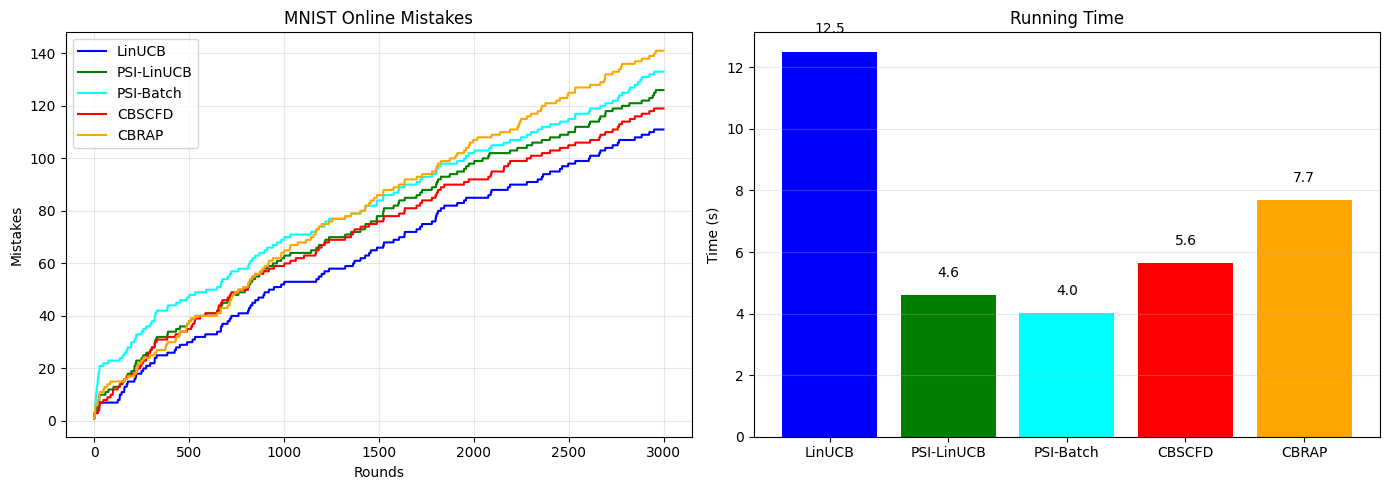


Final Results:
LinUCB: Mistakes=111.0, Time=12.5s
PSI-LinUCB: Mistakes=126.0, Time=4.6s
PSI-Batch: Mistakes=133.0, Time=4.0s
CBSCFD: Mistakes=119.0, Time=5.6s
CBRAP: Mistakes=141.0, Time=7.7s


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import time

T = 3000
n_runs = 1
d = 784
num_arms = 10

# LinUCB
alpha_lin = 0.0001
epsilon_lin = 0.2

# PSI-LinUCB
alpha_psi = 0.01
epsilon_psi = 1
rank_psi = 90

# PSI-Batch
alpha_psi_batch = 0.0001
epsilon_psi_batch = 1
rank_psi_batch = 100
batch_size = 25

# CBSCFD
beta_cbscfd = 0.001
lambd_cbscfd = 0.02
m_cbscfd = 100

# CBRAP
beta_cbrap = 0.0001
lambd_cbrap = 0.2
m_cbrap = 90

# # DBSL
# beta_dbsl = 0.001
# lambd_dbsl = 0.2
# sketch_dbsl = 50
# eps_dbsl = 8

results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'PSI-Batch', 'CBSCFD', 'CBRAP', #'DBSL'
                                 ]}
times = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'PSI-Batch', 'CBSCFD', 'CBRAP', #'DBSL'
                               ]}

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}")
    np.random.seed(run)

    linucb = LinUCB_SM(d, alpha_lin, epsilon_lin)
    psi = LinUCBwithPSI_rank1(d, epsilon_psi, alpha_psi, rank_psi)
    psi_batch = LinUCBwithPSI_Batch(d, epsilon_psi_batch, alpha_psi_batch, rank_psi_batch)
    cbscfd = CBSCFD(lambd_cbscfd, beta_cbscfd, m_cbscfd, d)
    cbrap = CBRAP(d, lambd_cbrap, beta_cbrap, m_cbrap)
    #dbsl = DBSL(d, sketch_size=sketch_dbsl, eps=eps_dbsl, beta=beta_dbsl, lmd=lambd_dbsl, robust=True)

    env_linucb = MNISTBanditEnv(clusters, target_class=0)
    env_psi = MNISTBanditEnv(clusters, target_class=0)
    env_psi_batch = MNISTBanditEnv(clusters, target_class=0)
    env_cbscfd = MNISTBanditEnv(clusters, target_class=0)
    env_cbrap = MNISTBanditEnv(clusters, target_class=0)
    #env_dbsl = MNISTBanditEnv(clusters, target_class=0)

    time_linucb, time_psi, time_psi_batch, time_cbscfd, time_cbrap, time_dbsl = 0, 0, 0, 0, 0, 0
    buffer = {'ctx': [], 'r': []}

    for t in trange(T, leave=False):
        np.random.seed(run * T + t)
        contexts = env_linucb.get_contexts()

        # LinUCB
        t0 = time.perf_counter()
        action = int(np.argmax([linucb.score(contexts[a]) for a in range(num_arms)]))
        reward = env_linucb.step(action)
        linucb.update(contexts[action], reward)
        time_linucb += time.perf_counter() - t0

        # PSI-LinUCB
        t0 = time.perf_counter()
        action = int(np.argmax([psi.score(contexts[a]) for a in range(num_arms)]))
        reward = env_psi.step(action)
        psi.update(contexts[action], reward)
        time_psi += time.perf_counter() - t0

        # PSI-Batch
        t0 = time.perf_counter()
        action = int(np.argmax([psi_batch.score(contexts[a]) for a in range(num_arms)]))
        reward = env_psi_batch.step(action)
        buffer['ctx'].append(contexts[action])
        buffer['r'].append(reward)

        if (t + 1) % batch_size == 0 and len(buffer['ctx']) > 0:
            X = np.column_stack(buffer['ctx'])
            r = np.array(buffer['r'])
            psi_batch.update(X, r)
            buffer = {'ctx': [], 'r': []}
        time_psi_batch += time.perf_counter() - t0

        # CBSCFD
        t0 = time.perf_counter()
        action = cbscfd.select_arm(contexts)
        reward = env_cbscfd.step(action)
        cbscfd.update(contexts[action], reward)
        time_cbscfd += time.perf_counter() - t0

        # CBRAP
        t0 = time.perf_counter()
        action = int(np.argmax([cbrap.score(contexts[a]) for a in range(num_arms)]))
        reward = env_cbrap.step(action)
        cbrap.update(contexts[action], reward)
        time_cbrap += time.perf_counter() - t0

        # # DBSL
        # t0 = time.perf_counter()
        # def observe(ind, x): return env_dbsl.step(ind)
        # dbsl.fit(contexts, observe)
        # time_dbsl += time.perf_counter() - t0

    # Финальное обновление буфера
    if len(buffer['ctx']) > 0:
        X = np.column_stack(buffer['ctx'])
        r = np.array(buffer['r'])
        psi_batch.update(X, r)

    results['LinUCB'].append(env_linucb.cumulative_mistakes)
    results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
    results['PSI-Batch'].append(env_psi_batch.cumulative_mistakes)
    results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)
    results['CBRAP'].append(env_cbrap.cumulative_mistakes)
    # results['DBSL'].append(env_dbsl.cumulative_mistakes)

    times['LinUCB'].append(time_linucb)
    times['PSI-LinUCB'].append(time_psi)
    times['PSI-Batch'].append(time_psi_batch)
    times['CBSCFD'].append(time_cbscfd)
    times['CBRAP'].append(time_cbrap)
    # times['DBSL'].append(time_dbsl)

# Графики
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График ошибок
ax = axes[0]
colors = {'LinUCB': 'blue', 'PSI-LinUCB': 'green', 'PSI-Batch': 'cyan', 'CBSCFD': 'red', 'CBRAP': 'orange', #'DBSL': 'purple'
          }
for name in results:
    arr = np.array(results[name])
    mean = np.mean(arr, axis=0)
    ax.plot(mean, label=name, color=colors[name])
ax.set_xlabel('Rounds')
ax.set_ylabel('Mistakes')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('MNIST Online Mistakes')

# График времени (столбчатый)
ax = axes[1]
names = list(times.keys())
mean_times = [np.mean(times[name]) for name in names]
bars = ax.bar(names, mean_times, color=[colors[name] for name in names])
ax.set_ylabel('Time (s)')
ax.set_title('Running Time')
ax.grid(True, alpha=0.3, axis='y')

for bar, t in zip(bars, mean_times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{t:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Результаты
print("\nFinal Results:")
for name in results:
    arr = np.array(results[name])
    print(f"{name}: Mistakes={np.mean(arr[:,-1]):.1f}, Time={np.mean(times[name]):.1f}s")